In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
BATCH_SIZE = 128
NUM_EPOCHS = 10
HIDDEN_SIZE = 500
NUM_CLASSES = 10
VAL_SPLIT = 0.1

In [4]:
train_data = torchvision.datasets.MNIST(root='./',train=True,transform=transforms.ToTensor(),download=True)
test_data = torchvision.datasets.MNIST(root='./',train=False,transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
class CNN(nn.Module):
  def __init__(self,num_classes=NUM_CLASSES):
    super(CNN,self).__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2,stride=2))
    self.layer2 = nn.Sequential(nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2,stride=2))
    self.fc1 = nn.Sequential(nn.Linear(7*7*32,HIDDEN_SIZE),
                             nn.ReLU())
    self.fc2 = nn.Linear(HIDDEN_SIZE,NUM_CLASSES)
  
  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.view(-1,7*7*32)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [6]:
CUDA_LAUNCH_BLOCKING=1

In [7]:
model = CNN().to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [9]:
total_steps = len(train_loader)
cost_train,cost_test,acc = [],[],[]
for epoch in range(NUM_EPOCHS):
  for i, (images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 50 == 0:
      print('Epoch:[{}/{}], Step:{}/{}, Loss:{:.6f}'.format(epoch+1,NUM_EPOCHS,i+1,total_steps,loss.item()))
      model.eval()
      with torch.no_grad():
        correct,total = 0,0
        for images,labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)

          preds = model(images)
          val_loss = criterion(preds,labels)
          _,pred = torch.max(preds.data,1)
          total += labels.size(0)
          correct += (pred == labels).sum().item()

        print('Test Loss:{:4f}, Test Accuracy:{:.4f}'.format(val_loss.item(),correct/total))
        cost_train.append(loss.item())
        acc.append(correct/total)
        cost_test.append(val_loss.item())
torch.save(model.state_dict(),'model.ckpt')

Epoch:[1/10], Step:50/469, Loss:0.404270
Test Loss:0.194243, Test Accuracy:0.8996
Epoch:[1/10], Step:100/469, Loss:0.207244
Test Loss:0.078703, Test Accuracy:0.9246
Epoch:[1/10], Step:150/469, Loss:0.158733
Test Loss:0.033173, Test Accuracy:0.9504
Epoch:[1/10], Step:200/469, Loss:0.189725
Test Loss:0.018304, Test Accuracy:0.9645
Epoch:[1/10], Step:250/469, Loss:0.064709
Test Loss:0.012498, Test Accuracy:0.9677
Epoch:[1/10], Step:300/469, Loss:0.176108
Test Loss:0.007238, Test Accuracy:0.9736
Epoch:[1/10], Step:350/469, Loss:0.128763
Test Loss:0.004087, Test Accuracy:0.9757
Epoch:[1/10], Step:400/469, Loss:0.041823
Test Loss:0.001879, Test Accuracy:0.9778
Epoch:[1/10], Step:450/469, Loss:0.076159
Test Loss:0.001606, Test Accuracy:0.9801
Epoch:[2/10], Step:50/469, Loss:0.081808
Test Loss:0.002154, Test Accuracy:0.9839
Epoch:[2/10], Step:100/469, Loss:0.044048
Test Loss:0.000722, Test Accuracy:0.9842
Epoch:[2/10], Step:150/469, Loss:0.115333
Test Loss:0.002548, Test Accuracy:0.9839
Epoch:

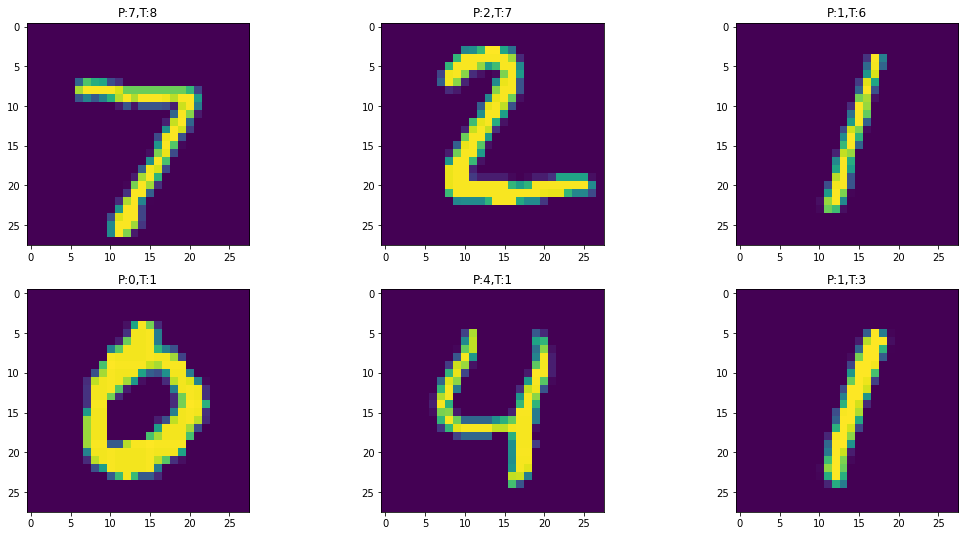

In [10]:
for img,label in test_loader:
  img = img.to(device)
  label = label.to(device)
  preds = model(img)
  fig = plt.figure(figsize=(18,9))
  fig.tight_layout()
  col,row = 3,2
  y_preds = torch.max(preds.data,1)[1].cpu().numpy()
  for i in range(1,col*row+1):
    a = fig.add_subplot(row,col,i)
    a.set_title('P:{},T:{}'.format(y_preds[i-1],labels.data[i-1]))
    plt.imshow(img[i-1,0].cpu().numpy())

  plt.show()
  break

## Using Batch Normalization

In [11]:
class CNN_BN(nn.Module):
  def __init__(self,num_classes=NUM_CLASSES):
    super(CNN_BN,self).__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
                                nn.ReLU(),
                                nn.BatchNorm2d(32),
                                nn.MaxPool2d(kernel_size=2,stride=2))
    self.layer2 = nn.Sequential(nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1),
                                nn.ReLU(),
                                nn.BatchNorm2d(32),
                                nn.MaxPool2d(kernel_size=2,stride=2))
    self.fc1 = nn.Sequential(nn.Linear(7*7*32,HIDDEN_SIZE),
                             nn.ReLU())
    self.fc2 = nn.Linear(HIDDEN_SIZE,NUM_CLASSES)

  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.view(-1,32*7*7)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [12]:
model_bn = CNN_BN().to(device)

In [13]:
optimizer = torch.optim.Adam(model_bn.parameters())

In [14]:
total_steps = len(train_loader)
cost_train_bn,cost_test_bn,acc_bn = [],[],[]
for epoch in range(NUM_EPOCHS):
  for i, (images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model_bn(images)
    loss = criterion(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 50 == 0:
      print('Epoch:[{}/{}], Step:{}/{}, Loss:{:.6f}'.format(epoch+1,NUM_EPOCHS,i+1,total_steps,loss.item()))
      model.eval()
      with torch.no_grad():
        correct,total = 0,0
        for images,labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          preds = model_bn(images)
          val_loss = criterion(preds,labels)
          _,pred = torch.max(preds.data,1)
          total += labels.size(0)
          correct += (pred == labels).sum().item()

        print('Test Loss:{:4f}, Test Accuracy:{:.4f}'.format(val_loss.item(),correct/total))
        cost_test_bn.append(val_loss.item())
        acc_bn.append(correct/total)
        cost_train_bn.append(loss.item())

Epoch:[1/10], Step:50/469, Loss:0.169553
Test Loss:0.008543, Test Accuracy:0.9602
Epoch:[1/10], Step:100/469, Loss:0.047702
Test Loss:0.012662, Test Accuracy:0.9693
Epoch:[1/10], Step:150/469, Loss:0.053036
Test Loss:0.001205, Test Accuracy:0.9788
Epoch:[1/10], Step:200/469, Loss:0.095076
Test Loss:0.001879, Test Accuracy:0.9813
Epoch:[1/10], Step:250/469, Loss:0.036623
Test Loss:0.001405, Test Accuracy:0.9799
Epoch:[1/10], Step:300/469, Loss:0.054162
Test Loss:0.003480, Test Accuracy:0.9853
Epoch:[1/10], Step:350/469, Loss:0.075564
Test Loss:0.001211, Test Accuracy:0.9826
Epoch:[1/10], Step:400/469, Loss:0.032643
Test Loss:0.001243, Test Accuracy:0.9836
Epoch:[1/10], Step:450/469, Loss:0.048062
Test Loss:0.000209, Test Accuracy:0.9879
Epoch:[2/10], Step:50/469, Loss:0.014809
Test Loss:0.000385, Test Accuracy:0.9858
Epoch:[2/10], Step:100/469, Loss:0.037833
Test Loss:0.001208, Test Accuracy:0.9823
Epoch:[2/10], Step:150/469, Loss:0.014793
Test Loss:0.000920, Test Accuracy:0.9887
Epoch:

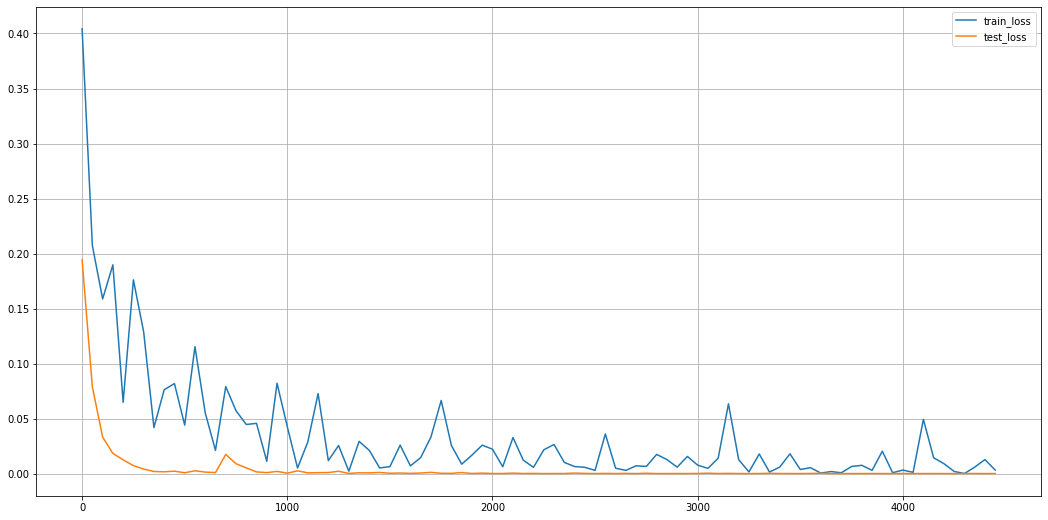

In [15]:
x = 50*np.arange(len(cost_train))
plt.figure(figsize=(18,9))
plt.plot(x,cost_train,label='train_loss')
plt.plot(x,cost_test,label='test_loss')
plt.legend()
plt.grid()
plt.show()

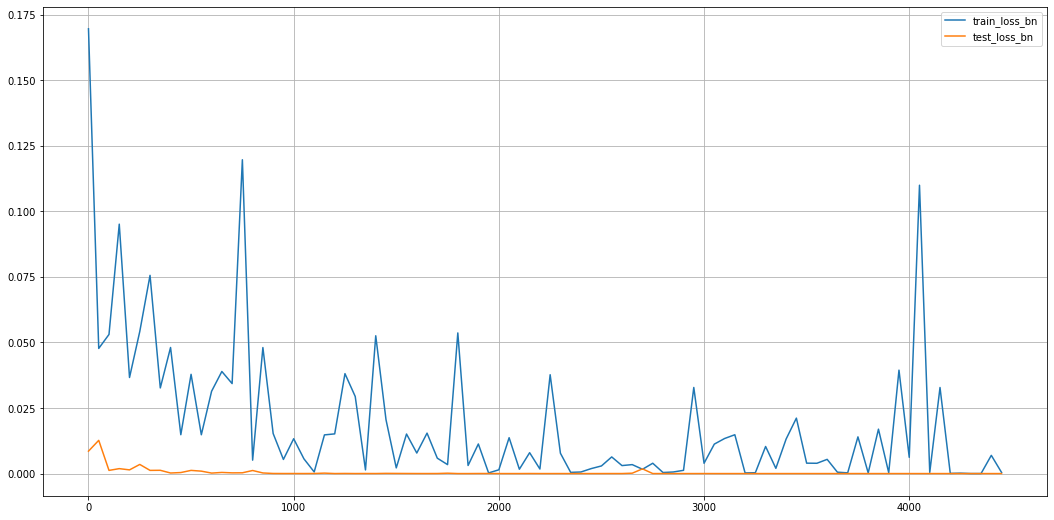

In [16]:
x = 50*np.arange(len(cost_train))
plt.figure(figsize=(18,9))
plt.plot(x,cost_train_bn,label='train_loss_bn')
plt.plot(x,cost_test_bn,label='test_loss_bn')
plt.legend()
plt.grid()
plt.show()

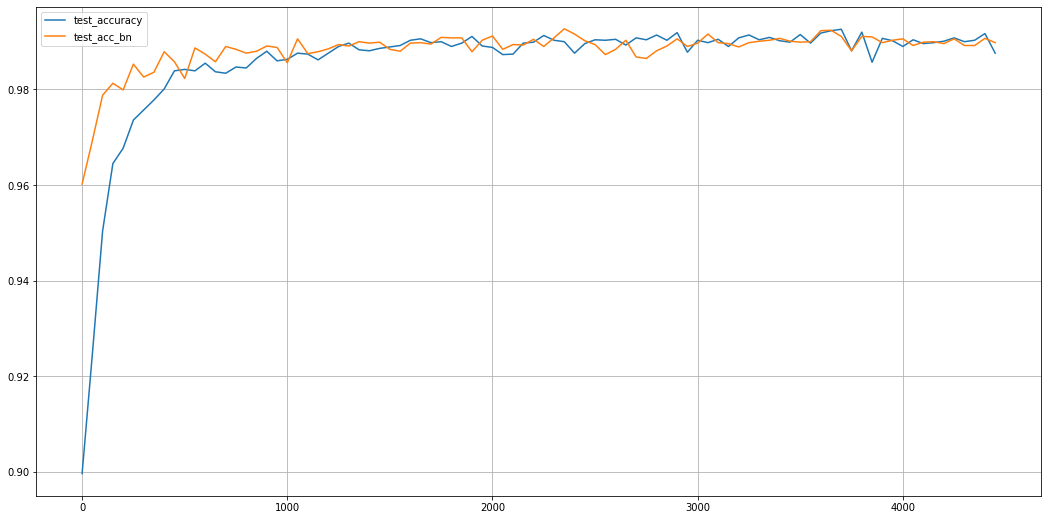

In [17]:
x = 50*np.arange(len(cost_train))
plt.figure(figsize=(18,9))
plt.plot(x,acc,label='test_accuracy')
plt.plot(x,acc_bn,label='test_acc_bn')
plt.legend()
plt.grid()
plt.show()

In [18]:
torch.save(model_bn.state_dict(),'model_bn.ckpt')

In [19]:
checkpoint = torch.load('model.ckpt')
model = CNN().to(device)
model.load_state_dict(checkpoint)
model.eval()
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

layer1.0.weight 	 torch.Size([32, 1, 3, 3])
layer1.0.bias 	 torch.Size([32])
layer2.0.weight 	 torch.Size([32, 32, 3, 3])
layer2.0.bias 	 torch.Size([32])
fc1.0.weight 	 torch.Size([500, 1568])
fc1.0.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 torch.Size([10])


In [20]:
conv1_layer = model.state_dict()['layer1.0.weight'].cpu().numpy()
conv2_layer = model.state_dict()['layer2.0.weight'].cpu().numpy()

In [21]:
def normalize(x,eps=1e-8):
  out = np.zeros_like(x)
  for i in range(x.shape[0]):
    high,low = np.amax(x[i]),np.amin(x[i])
    out[i] = (x[i]-low)/(high-low+eps)
  
  out = out*255
  out = out.astype(np.uint8)
  return out

conv1_layer_normal = normalize(conv1_layer)
conv2_layer_normal = normalize(conv2_layer)

In [22]:
print(conv1_layer_normal.shape)

(32, 1, 3, 3)


In [23]:
conv1_layer_normal = conv1_layer_normal.reshape(32,3,3)

In [24]:
print(conv2_layer_normal.shape)

(32, 32, 3, 3)


## Visualizing the convolutional layer filters

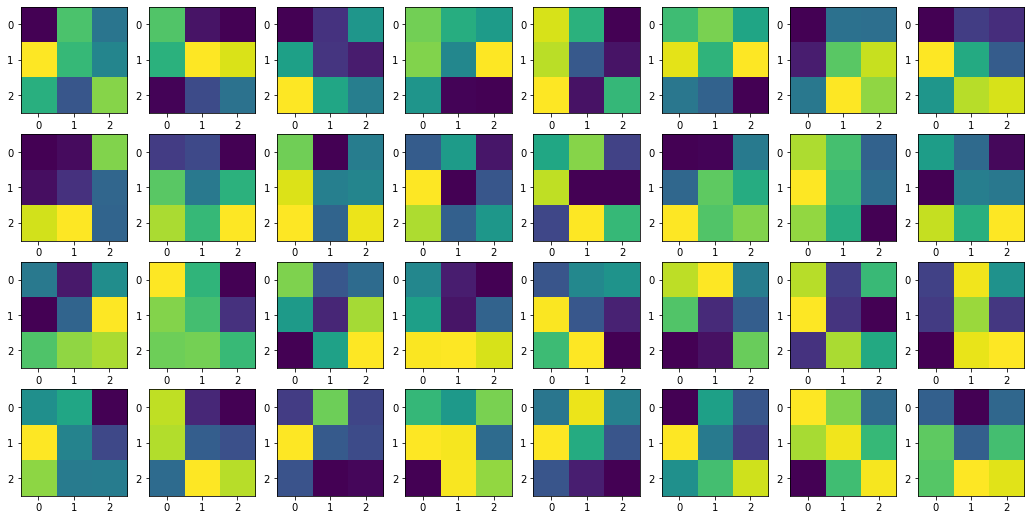

In [25]:
fig = plt.figure(figsize=(18,9))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(conv1_layer_normal[i-1])

plt.show()

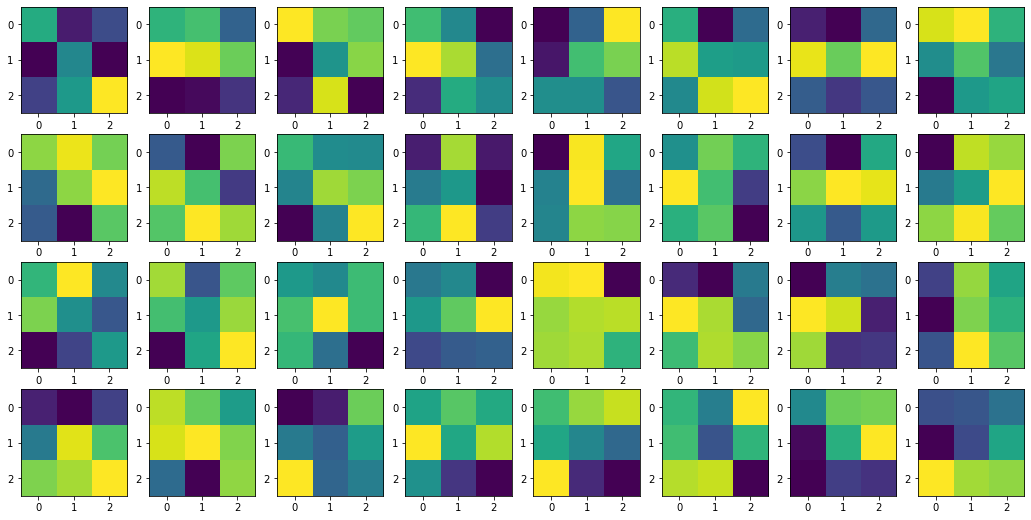

In [26]:
fig = plt.figure(figsize=(18,9))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(conv2_layer_normal[i-1,7])

plt.show()

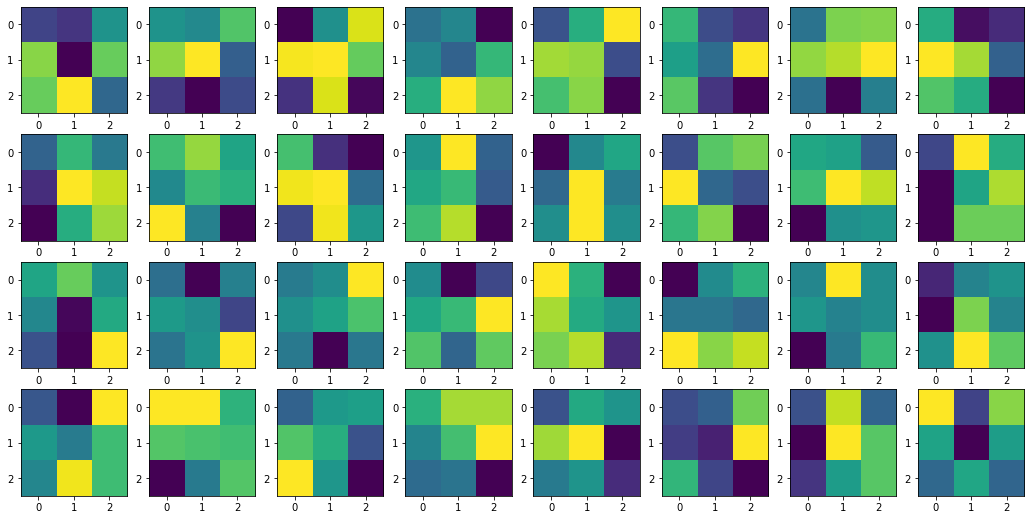

In [27]:
fig = plt.figure(figsize=(18,9))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(conv2_layer_normal[i-1,23])

plt.show()

## Visualizing Activation Maps

In [28]:
visualize_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=1,shuffle=False)

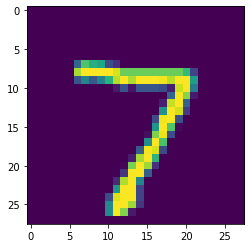

conv1 output shape: (32, 14, 14)
conv2 output shape: (32, 7, 7)


In [29]:
for images,labels in visualize_loader:
  images = images.to(device)
  labels = labels.to(device)
  img = images.cpu().numpy().reshape(28,28)
  plt.imshow(img)
  plt.show()

  layer1_out = model.layer1(images)
  layer1_out_np = layer1_out.cpu().detach().numpy().reshape(32,14,14)
  print('conv1 output shape:',layer1_out_np.shape)

  layer2_out = model.layer2(layer1_out)
  layer2_out_np = layer2_out.cpu().detach().numpy().reshape(32,7,7)
  print('conv2 output shape:',layer2_out_np.shape)

  break


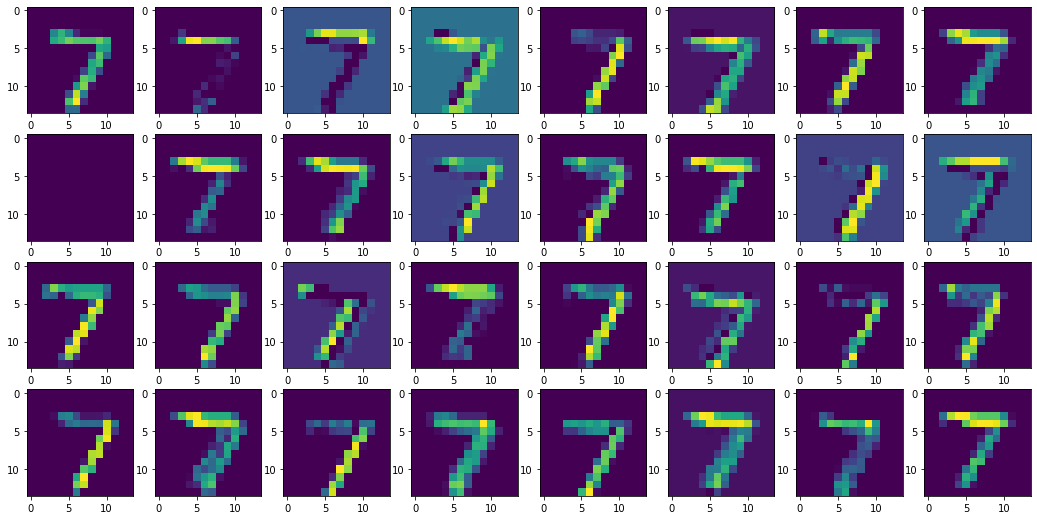

In [30]:
fig = plt.figure(figsize=(18,9))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(layer1_out_np[i-1])

plt.show()

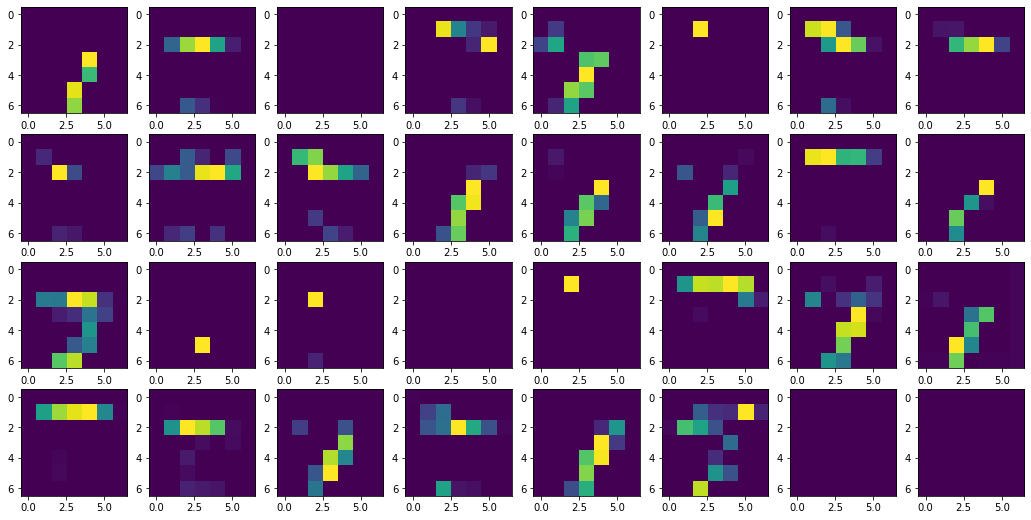

In [31]:
fig = plt.figure(figsize=(18,9))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(layer2_out_np[i-1])

plt.show()

## Occluding parts of the image

In [32]:
def occluded_image(x,i,j,patch_size=14):
  """
   We propose to use 16 7x7 grey patches to occlude. So, total 16 images will be generated.
  """
  y = x.copy()
  y[i:i+patch_size,j:j+patch_size] = 0.5
  return y

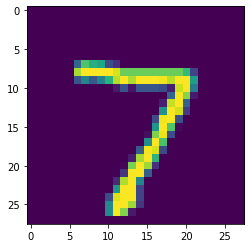

Figure:1, Actual Class:7, Probability:1.0000, Predicted:7
Figure:2, Actual Class:7, Probability:0.8804, Predicted:7
Figure:3, Actual Class:7, Probability:0.9996, Predicted:7
Figure:4, Actual Class:7, Probability:0.9997, Predicted:7
Figure:5, Actual Class:7, Probability:0.9923, Predicted:7
Figure:6, Actual Class:7, Probability:0.9999, Predicted:7
Figure:7, Actual Class:7, Probability:0.9997, Predicted:7
Figure:8, Actual Class:7, Probability:0.9983, Predicted:7
Figure:9, Actual Class:7, Probability:0.9999, Predicted:7


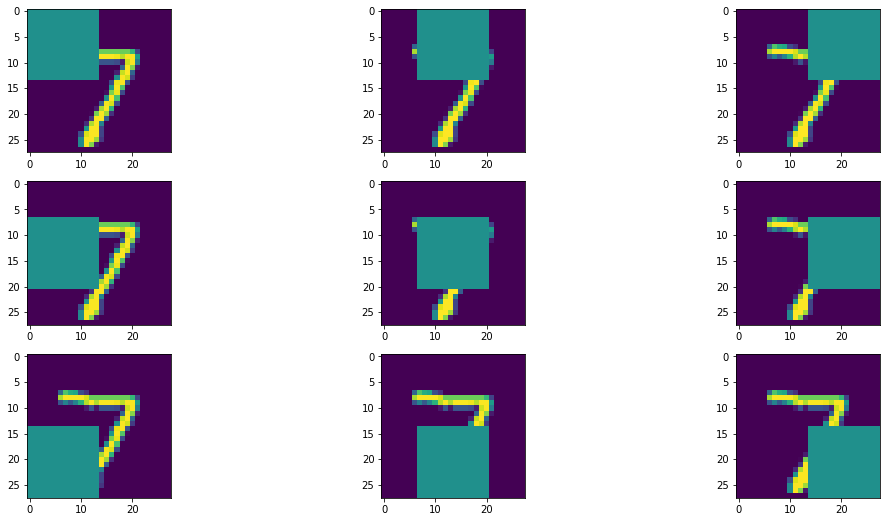

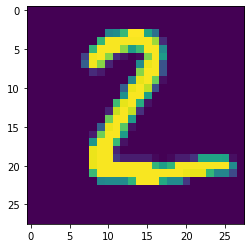

Figure:1, Actual Class:2, Probability:1.0000, Predicted:2
Figure:2, Actual Class:2, Probability:1.0000, Predicted:2
Figure:3, Actual Class:2, Probability:1.0000, Predicted:2
Figure:4, Actual Class:2, Probability:1.0000, Predicted:2
Figure:5, Actual Class:2, Probability:0.9999, Predicted:2
Figure:6, Actual Class:2, Probability:0.9999, Predicted:2
Figure:7, Actual Class:2, Probability:1.0000, Predicted:2
Figure:8, Actual Class:2, Probability:1.0000, Predicted:2
Figure:9, Actual Class:2, Probability:1.0000, Predicted:2


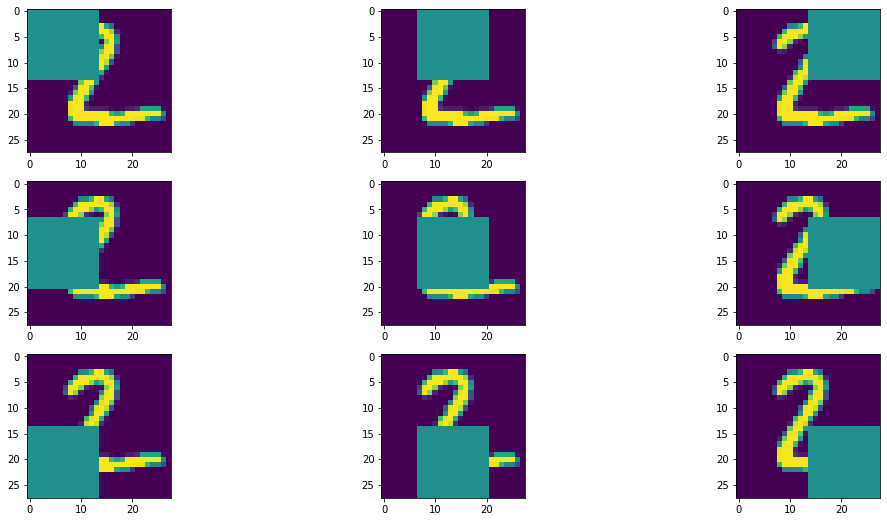

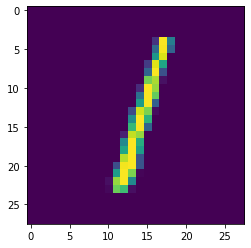

Figure:1, Actual Class:1, Probability:0.9072, Predicted:1
Figure:2, Actual Class:1, Probability:0.3822, Predicted:8
Figure:3, Actual Class:1, Probability:0.1343, Predicted:8
Figure:4, Actual Class:1, Probability:0.8077, Predicted:1
Figure:5, Actual Class:1, Probability:0.0213, Predicted:7
Figure:6, Actual Class:1, Probability:0.6767, Predicted:1
Figure:7, Actual Class:1, Probability:0.9944, Predicted:1
Figure:8, Actual Class:1, Probability:0.2406, Predicted:4
Figure:9, Actual Class:1, Probability:0.9742, Predicted:1


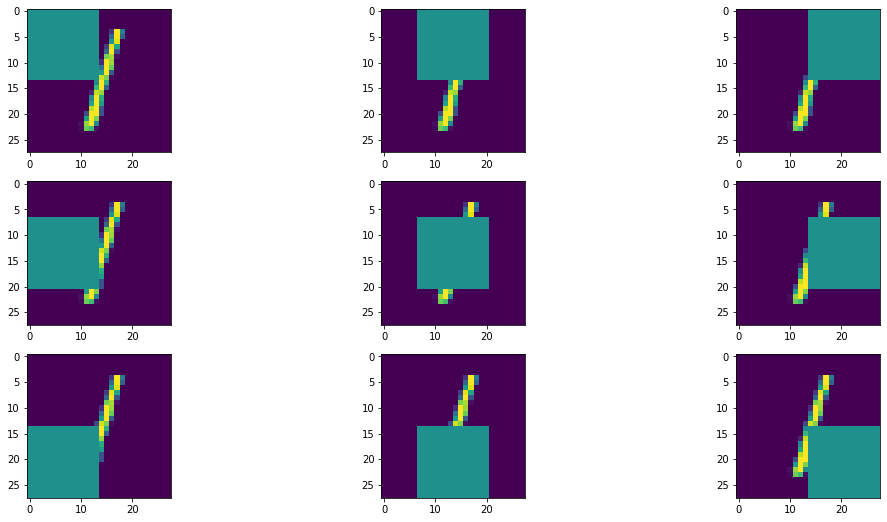

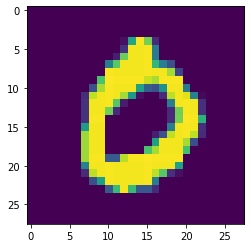

Figure:1, Actual Class:0, Probability:1.0000, Predicted:0
Figure:2, Actual Class:0, Probability:0.9088, Predicted:0
Figure:3, Actual Class:0, Probability:0.9564, Predicted:0
Figure:4, Actual Class:0, Probability:1.0000, Predicted:0
Figure:5, Actual Class:0, Probability:0.9936, Predicted:0
Figure:6, Actual Class:0, Probability:0.9957, Predicted:0
Figure:7, Actual Class:0, Probability:0.9922, Predicted:0
Figure:8, Actual Class:0, Probability:0.2361, Predicted:7
Figure:9, Actual Class:0, Probability:1.0000, Predicted:0


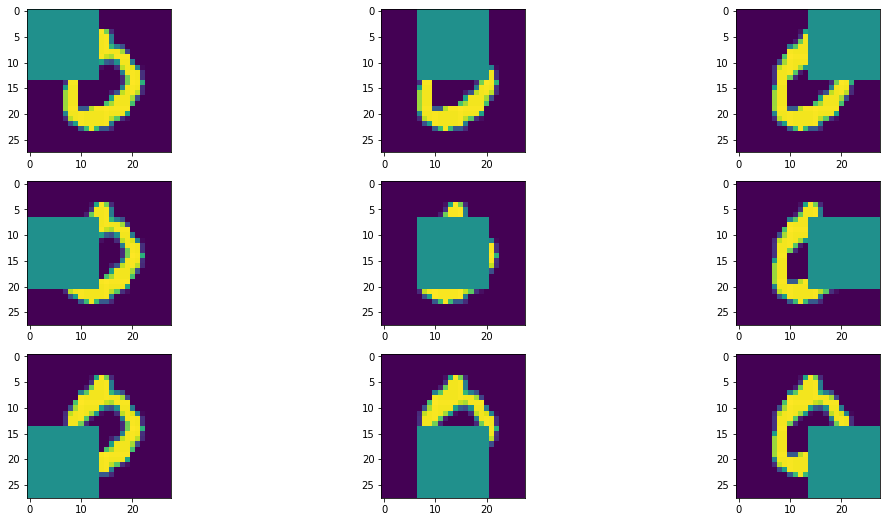

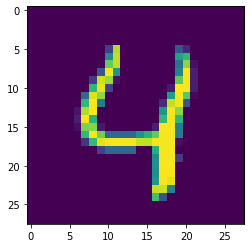

Figure:1, Actual Class:4, Probability:1.0000, Predicted:4
Figure:2, Actual Class:4, Probability:0.8236, Predicted:4
Figure:3, Actual Class:4, Probability:0.9829, Predicted:4
Figure:4, Actual Class:4, Probability:0.9999, Predicted:4
Figure:5, Actual Class:4, Probability:0.0352, Predicted:7
Figure:6, Actual Class:4, Probability:0.6575, Predicted:4
Figure:7, Actual Class:4, Probability:1.0000, Predicted:4
Figure:8, Actual Class:4, Probability:0.9992, Predicted:4
Figure:9, Actual Class:4, Probability:1.0000, Predicted:4


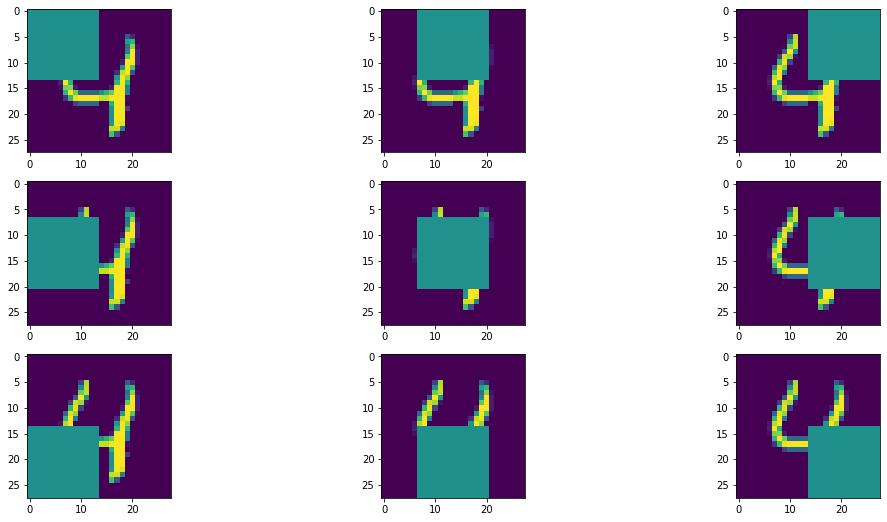

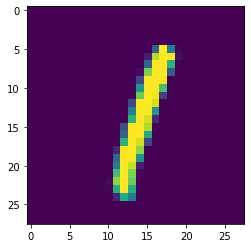

Figure:1, Actual Class:1, Probability:0.8151, Predicted:1
Figure:2, Actual Class:1, Probability:0.2137, Predicted:8
Figure:3, Actual Class:1, Probability:0.1603, Predicted:8
Figure:4, Actual Class:1, Probability:0.9538, Predicted:1
Figure:5, Actual Class:1, Probability:0.0074, Predicted:7
Figure:6, Actual Class:1, Probability:0.7415, Predicted:1
Figure:7, Actual Class:1, Probability:0.9962, Predicted:1
Figure:8, Actual Class:1, Probability:0.3944, Predicted:7
Figure:9, Actual Class:1, Probability:0.9932, Predicted:1


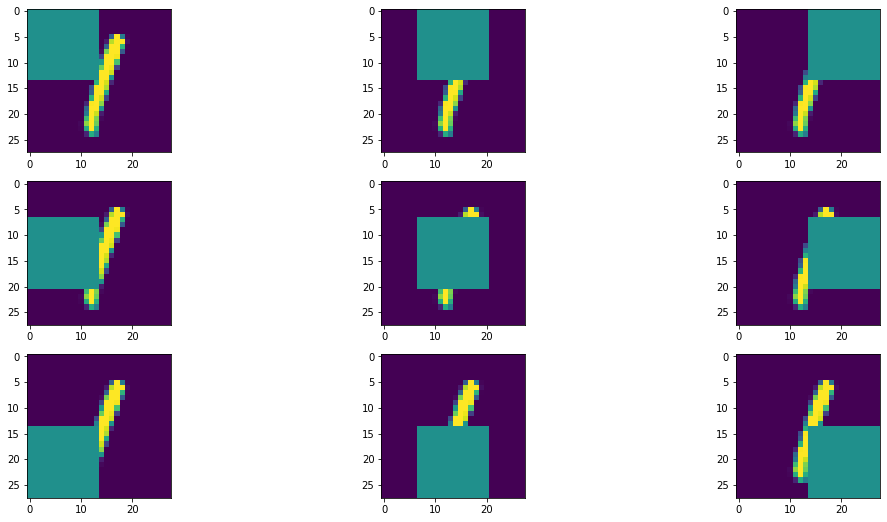

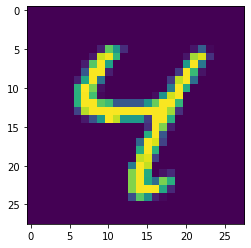

Figure:1, Actual Class:4, Probability:0.9976, Predicted:4
Figure:2, Actual Class:4, Probability:0.6499, Predicted:4
Figure:3, Actual Class:4, Probability:0.9924, Predicted:4
Figure:4, Actual Class:4, Probability:0.9497, Predicted:4
Figure:5, Actual Class:4, Probability:0.1442, Predicted:7
Figure:6, Actual Class:4, Probability:0.9163, Predicted:4
Figure:7, Actual Class:4, Probability:0.9291, Predicted:4
Figure:8, Actual Class:4, Probability:0.2908, Predicted:8
Figure:9, Actual Class:4, Probability:0.9999, Predicted:4


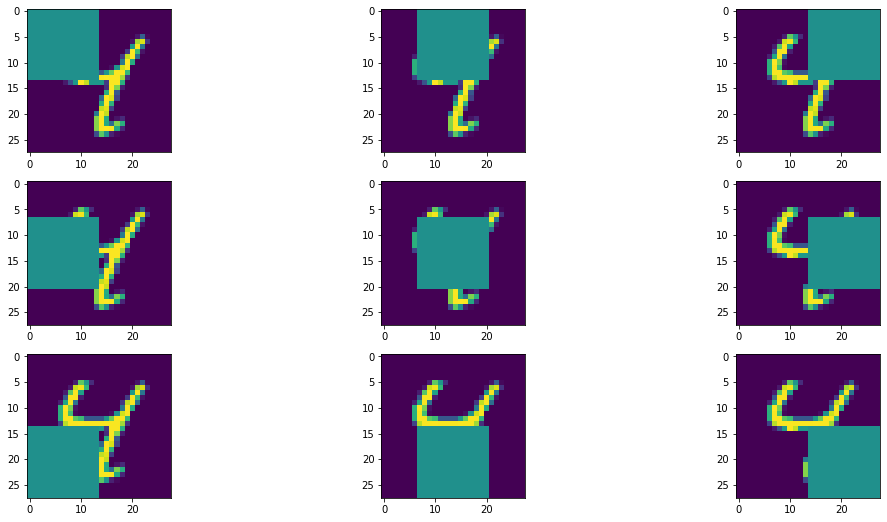

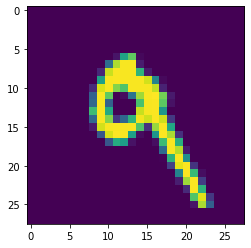

Figure:1, Actual Class:9, Probability:0.9960, Predicted:9
Figure:2, Actual Class:9, Probability:0.9415, Predicted:9
Figure:3, Actual Class:9, Probability:0.9999, Predicted:9
Figure:4, Actual Class:9, Probability:0.1315, Predicted:1
Figure:5, Actual Class:9, Probability:0.9951, Predicted:9
Figure:6, Actual Class:9, Probability:1.0000, Predicted:9
Figure:7, Actual Class:9, Probability:0.9480, Predicted:9
Figure:8, Actual Class:9, Probability:0.9956, Predicted:9
Figure:9, Actual Class:9, Probability:0.9997, Predicted:9


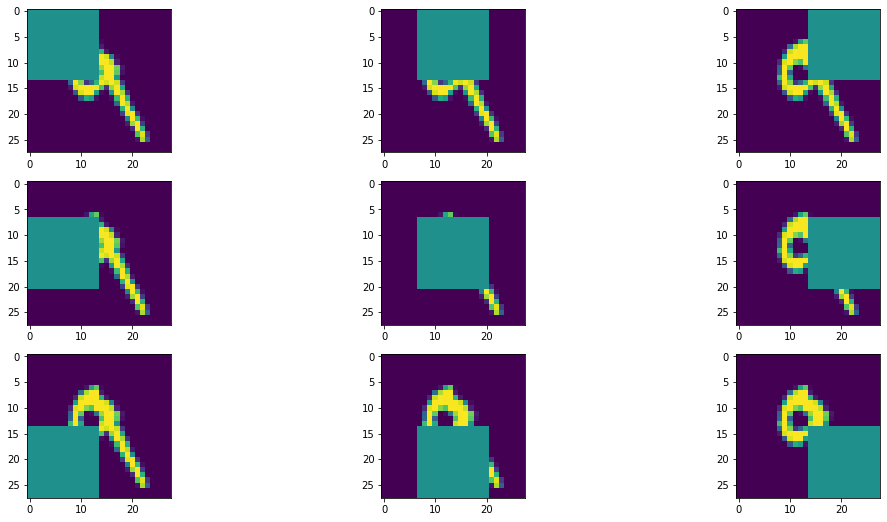

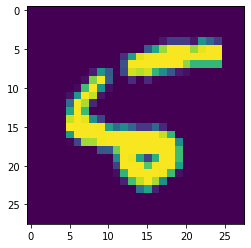

Figure:1, Actual Class:5, Probability:0.9986, Predicted:5
Figure:2, Actual Class:5, Probability:0.0247, Predicted:6
Figure:3, Actual Class:5, Probability:0.5333, Predicted:5
Figure:4, Actual Class:5, Probability:0.9984, Predicted:5
Figure:5, Actual Class:5, Probability:0.4817, Predicted:0
Figure:6, Actual Class:5, Probability:0.1149, Predicted:8
Figure:7, Actual Class:5, Probability:0.9997, Predicted:5
Figure:8, Actual Class:5, Probability:0.3574, Predicted:9
Figure:9, Actual Class:5, Probability:0.9681, Predicted:5


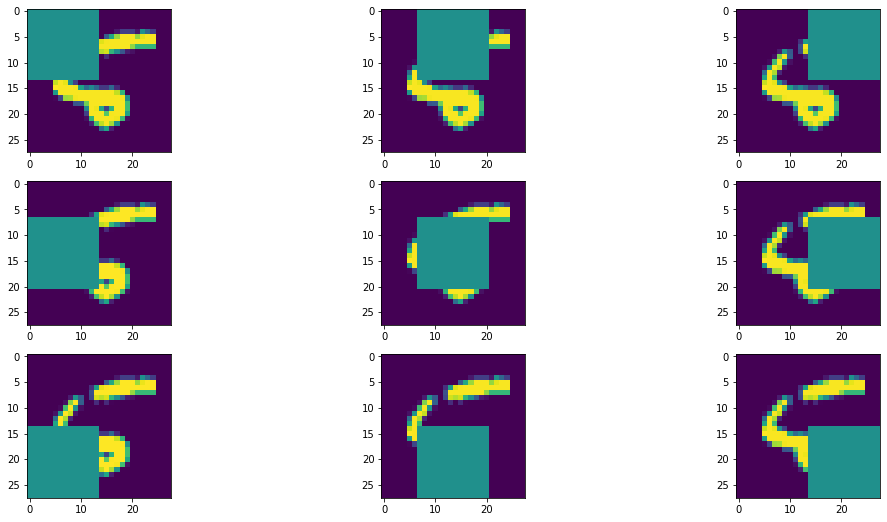

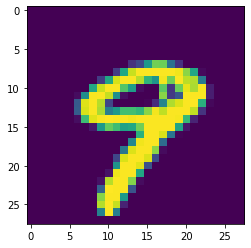

Figure:1, Actual Class:9, Probability:0.9732, Predicted:9
Figure:2, Actual Class:9, Probability:0.0665, Predicted:4
Figure:3, Actual Class:9, Probability:0.5369, Predicted:9
Figure:4, Actual Class:9, Probability:0.7074, Predicted:9
Figure:5, Actual Class:9, Probability:0.0049, Predicted:7
Figure:6, Actual Class:9, Probability:0.9935, Predicted:9
Figure:7, Actual Class:9, Probability:0.9992, Predicted:9
Figure:8, Actual Class:9, Probability:0.9127, Predicted:9
Figure:9, Actual Class:9, Probability:0.9997, Predicted:9


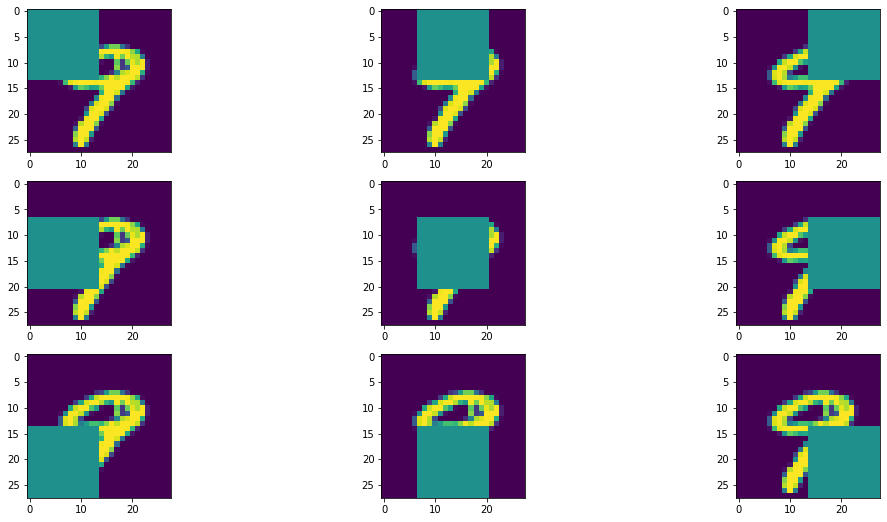

In [33]:
cnt = 0
for images,labels in visualize_loader:
  images = images.to(device)
  labels = labels.to(device)
  img = images.cpu().numpy().reshape(28,28)
  plt.imshow(img)
  plt.show()

  fig = plt.figure(figsize=(18,9))
  col,row = 3,3
  for i in range(1,10):
    fig.add_subplot(row,col,i)
    oc_image = occluded_image(img,7*int((i-1)/3),7*((i-1)%3))
    plt.imshow(oc_image)
    image = torch.from_numpy(oc_image.reshape(1,1,28,28))
    image = image.to(device)
    preds = model(image)
    for ii in labels.cpu().numpy():
      idx = ii
    
    pred_ = preds.data.cpu().numpy()
    predicted = np.argmax(pred_)
    pred_ = np.exp(pred_)/np.sum(np.exp(pred_))
    print('Figure:{}, Actual Class:{}, Probability:{:.4f}, Predicted:{}'.format(i,idx,pred_[0,idx],predicted))

  plt.show()
  cnt += 1
  if cnt == 10:
    break


# Adversarial Example
Adversarial Examples are used to fool the neural networks.
## Non-Targeted Attack

In [34]:
for child in model.children():
  for param in child.parameters():
    param.requires_grad = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Target Class:0, Iteration:0,Cost:tensor([1.5976], device='cuda:0'), Predicted Class:tensor([3], device='cuda:0')
Target Class:0, Iteration:500,Cost:tensor([297.8331], device='cuda:0'), Predicted Class:tensor([0], device='cuda:0')
Target Class:0, Iteration:1000,Cost:tensor([1376.4091], device='cuda:0'), Predicted Class:tensor([0], device='cuda:0')
Target Class:0, Iteration:1500,Cost:tensor([3296.5916], device='cuda:0'), Predicted Class:tensor([0], device='cuda:0')
Target Class:1, Iteration:0,Cost:tensor([1.2956], device='cuda:0'), Predicted Class:tensor([3], device='cuda:0')
Target Class:1, Iteration:500,Cost:tensor([254.5090], device='cuda:0'), Predicted Class:tensor([1], device='cuda:0')
Target Class:1, Iteration:1000,Cost:tensor([1492.6057], device='cuda:0'), Predicted Class:tensor([1], device='cuda:0')
Target Class:1, Iteration:1500,Cost:tensor([3899.4675], device='cuda:0'), Predicted Class:tensor([1], device='cuda:0')
Target Class:2, Iteration:0,Cost:tensor([1.4438], device='cuda:0

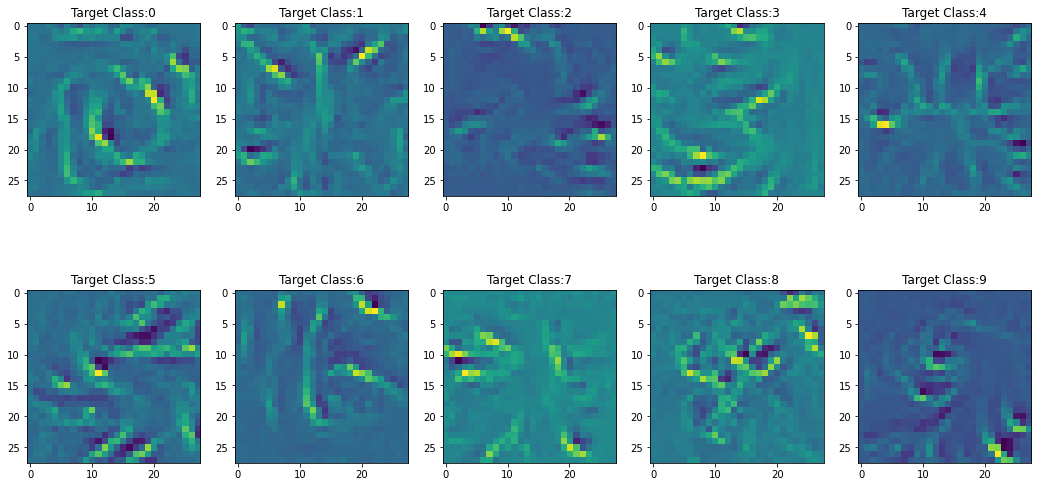

In [35]:
  img_grid = np.zeros((NUM_CLASSES,28,28))
  for i in range(NUM_CLASSES):
    image_nt = np.random.normal(loc=0.5, scale=0.05, size=(1,1,28,28)).astype(np.float32)
    image_nt = torch.from_numpy(image_nt)
    image_nt = image_nt.to(device)
    x_var = torch.tensor(image_nt.type(torch.cuda.FloatTensor), requires_grad=True, device='cuda')
    optimizer = torch.optim.SGD([x_var],lr=0.0001)
    for j in range(2000):
      model.zero_grad()
      out_var = model(x_var)
      loss = -out_var[0][i] 
      loss.backward()
      optimizer.step()

      if j%500 == 0:
        print('Target Class:{}, Iteration:{},Cost:{}, Predicted Class:{}'.format(i,j,torch.max(out_var.data,1)[0],
                                                                                                torch.max(out_var.data,1)[1]))
    n_img = x_var.cpu().detach().numpy()
    img_grid[i,:,:] = normalize(n_img)
  
  fig = plt.figure(figsize=(18,9))
  col,row = 5,2
  for i in range(1,11):
    ax = fig.add_subplot(row,col,i)
    ax.title.set_text('Target Class:{}'.format(i-1))
    plt.imshow(img_grid[i-1])
  plt.show()


## Targeted Task

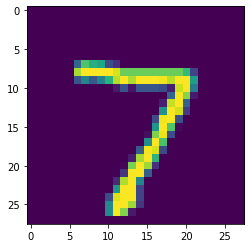

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Target Class:0, Iteration:0,Cost:tensor([0.8228], device='cuda:0'), Predicted Class:tensor([3], device='cuda:0'),Desired Class:tensor([7])
Target Class:0, Iteration:500,Cost:tensor([10.1666], device='cuda:0'), Predicted Class:tensor([7], device='cuda:0'),Desired Class:tensor([7])
Target Class:0, Iteration:1000,Cost:tensor([10.8517], device='cuda:0'), Predicted Class:tensor([0], device='cuda:0'),Desired Class:tensor([7])
Target Class:0, Iteration:1500,Cost:tensor([3.9559], device='cuda:0'), Predicted Class:tensor([0], device='cuda:0'),Desired Class:tensor([7])
Target Class:1, Iteration:0,Cost:tensor([1.3698], device='cuda:0'), Predicted Class:tensor([3], device='cuda:0'),Desired Class:tensor([7])
Target Class:1, Iteration:500,Cost:tensor([16.9088], device='cuda:0'), Predicted Class:tensor([7], device='cuda:0'),Desired Class:tensor([7])
Target Class:1, Iteration:1000,Cost:tensor([20.7027], device='cuda:0'), Predicted Class:tensor([7], device='cuda:0'),Desired Class:tensor([7])
Target Cla

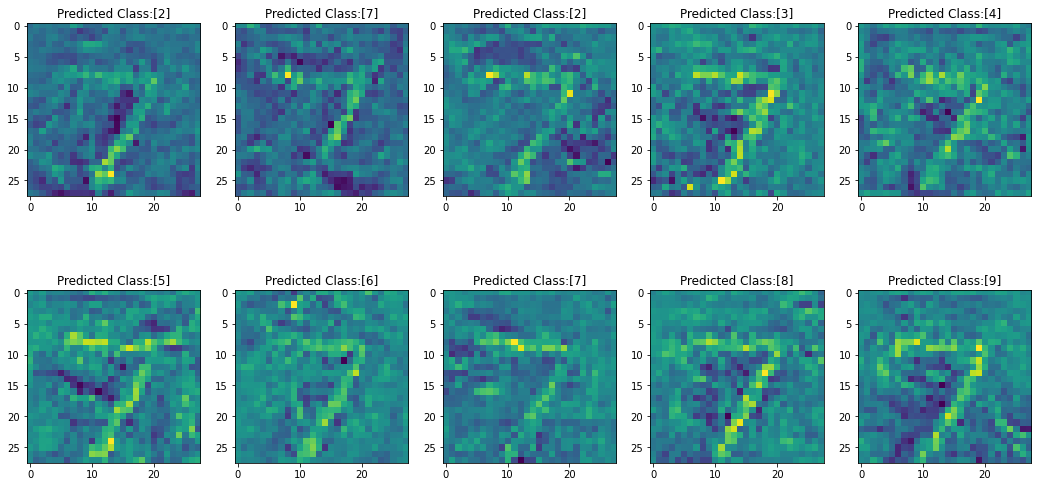

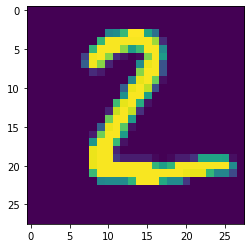

Target Class:0, Iteration:0,Cost:tensor([1.7586], device='cuda:0'), Predicted Class:tensor([3], device='cuda:0'),Desired Class:tensor([2])
Target Class:0, Iteration:500,Cost:tensor([24.1221], device='cuda:0'), Predicted Class:tensor([2], device='cuda:0'),Desired Class:tensor([2])
Target Class:0, Iteration:1000,Cost:tensor([35.6093], device='cuda:0'), Predicted Class:tensor([2], device='cuda:0'),Desired Class:tensor([2])
Target Class:0, Iteration:1500,Cost:tensor([4.4359], device='cuda:0'), Predicted Class:tensor([2], device='cuda:0'),Desired Class:tensor([2])
Target Class:1, Iteration:0,Cost:tensor([1.7337], device='cuda:0'), Predicted Class:tensor([3], device='cuda:0'),Desired Class:tensor([2])
Target Class:1, Iteration:500,Cost:tensor([27.3855], device='cuda:0'), Predicted Class:tensor([2], device='cuda:0'),Desired Class:tensor([2])
Target Class:1, Iteration:1000,Cost:tensor([28.7777], device='cuda:0'), Predicted Class:tensor([2], device='cuda:0'),Desired Class:tensor([2])
Target Cla

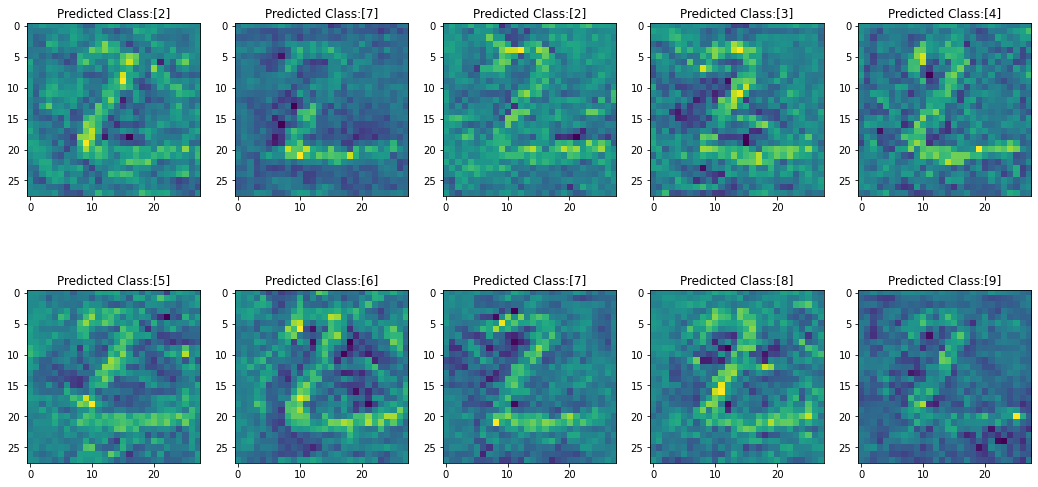

In [36]:
b = 1000
count = 0
preds = []
for img,label in visualize_loader:
  count += 1
  img = img.to(device)
  plt.imshow(img[0,0].cpu().numpy().clip(0,1))
  plt.show()
  img_grid = np.zeros((NUM_CLASSES,28,28))
  for i in range(NUM_CLASSES):
    image_nt = np.random.normal(loc=0.5, scale=0.05, size=(1,1,28,28)).astype(np.float32)
    image_nt = torch.from_numpy(image_nt)
    image_nt = image_nt.to(device)
    x_var = torch.tensor(image_nt.type(torch.cuda.FloatTensor), requires_grad=True, device='cuda')
    optimizer = torch.optim.SGD([x_var],lr=0.0001)
    for j in range(2000):
      model.zero_grad()
      out_var = model(x_var)
      mse_loss = nn.MSELoss()
      loss = -out_var[0][i] + b*mse_loss(x_var,img)
      loss.backward()
      optimizer.step()

      if j%500 == 0:
        print('Target Class:{}, Iteration:{},Cost:{}, Predicted Class:{},Desired Class:{}'.format(i,j,torch.max(out_var.data,1)[0],
                                                                                                torch.max(out_var.data,1)[1],label))
    n_img = x_var.cpu().detach().numpy()
    img_grid[i,:,:] = normalize(n_img)
    z = model(x_var)
    preds.append(np.argmax(z.cpu().detach().numpy(),axis=1))
  
  fig = plt.figure(figsize=(18,9))
  col,row = 5,2
  for i in range(1,11):
    ax = fig.add_subplot(row,col,i)
    ax.title.set_text('Predicted Class:{}'.format(preds[i-1]))
    plt.imshow(img_grid[i-1])
  plt.show()

  if count == 2:
    break


## Adding Noise

In [37]:
count = 0
limit = 5
target = 7 # Put the class id for which class you want to generate. So, here we try to convert every image into 7.
o_img_grid = np.zeros((limit,28,28))
n_img_grid = np.zeros_like(o_img_grid)
n_noise_grid = np.zeros_like(o_img_grid)
for img,label in visualize_loader:
  count += 1
  img = img.to(device)
  noise = torch.zeros((1,1,28,28),requires_grad=True,device='cuda')
  optimizer = torch.optim.SGD([noise],lr=0.001)
  for j in range(1000):
    optimizer.zero_grad()
    out_var = model(img + noise)
    loss = -out_var[0][target] 
    loss.backward()
    optimizer.step()
    if j%200 == 0:
      out_var_ = out_var.cpu().detach().numpy()
      out_var_ -= np.max(out_var_)
      out_var_ = np.exp(out_var_)/np.sum(np.exp(out_var_))

      print('Iteration:{},Cost:{}, Probability of Predicted Class({}):{:.6f}, Actual Class:{}'.format(j,torch.max(out_var.data,1)[0], target,
                                                                                                 out_var_[0][target],label))
  img1 = img + noise
  o_img = img.cpu().detach().numpy()                                        
  n_img = img1.cpu().detach().numpy()
  n_noise = noise.cpu().detach().numpy()

  o_img_grid[count-1,:,:] = o_img
  n_img_grid[count-1,:,:] = n_img
  n_noise_grid[count-1,:,:] = n_noise

  if count == limit:
    break


Iteration:0,Cost:tensor([12.6271], device='cuda:0'), Probability of Predicted Class(7):0.999949, Actual Class:tensor([7])
Iteration:200,Cost:tensor([22.4002], device='cuda:0'), Probability of Predicted Class(7):1.000000, Actual Class:tensor([7])
Iteration:400,Cost:tensor([30.8137], device='cuda:0'), Probability of Predicted Class(7):1.000000, Actual Class:tensor([7])
Iteration:600,Cost:tensor([39.1285], device='cuda:0'), Probability of Predicted Class(7):1.000000, Actual Class:tensor([7])
Iteration:800,Cost:tensor([48.7511], device='cuda:0'), Probability of Predicted Class(7):1.000000, Actual Class:tensor([7])
Iteration:0,Cost:tensor([24.5218], device='cuda:0'), Probability of Predicted Class(7):0.000000, Actual Class:tensor([2])
Iteration:200,Cost:tensor([23.2042], device='cuda:0'), Probability of Predicted Class(7):0.000000, Actual Class:tensor([2])
Iteration:400,Cost:tensor([19.9188], device='cuda:0'), Probability of Predicted Class(7):0.000028, Actual Class:tensor([2])
Iteration:60

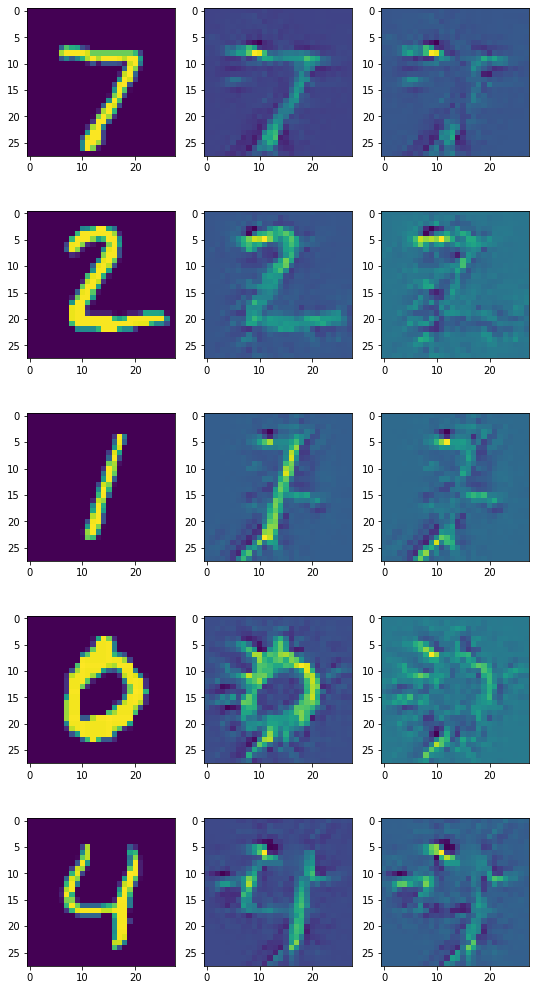

In [38]:
fig = plt.figure(figsize=(9,18))
col,row = 3,5
for i in range(1,16,3):
  ax = fig.add_subplot(row,col,i)
  plt.imshow(o_img_grid[(i-1)//3])

  ax = fig.add_subplot(row,col,i+1)
  plt.imshow(n_img_grid[(i-1)//3])

  ax = fig.add_subplot(row,col,i+2)
  plt.imshow(n_noise_grid[(i-1)//3])

plt.show()

In [39]:
count = 0
limit = 5
target = 4 # Put the class id for which class you want to generate. So, here we try to convert every image into 4.
o_img_grid = np.zeros((limit,28,28))
n_img_grid = np.zeros_like(o_img_grid)
n_noise_grid = np.zeros_like(o_img_grid)
for img,label in visualize_loader:
  count += 1
  img = img.to(device)
  noise = torch.zeros((1,1,28,28),requires_grad=True,device='cuda')
  optimizer = torch.optim.SGD([noise],lr=0.001)
  for j in range(1000):
    optimizer.zero_grad()
    out_var = model(img + noise)
    loss = -out_var[0][target] 
    loss.backward()
    optimizer.step()
    if j%200 == 0:
      out_var_ = out_var.cpu().detach().numpy()
      out_var_ -= np.max(out_var_)
      out_var_ = np.exp(out_var_)/np.sum(np.exp(out_var_))

      print('Iteration:{},Cost:{}, Probability of Predicted Class({}):{:.6f}, Actual Class:{}'.format(j,torch.max(out_var.data,1)[0], target,
                                                                                                 out_var_[0][target],label))
  img1 = img + noise
  o_img = img.cpu().detach().numpy()                                        
  n_img = img1.cpu().detach().numpy()
  n_noise = noise.cpu().detach().numpy()

  o_img_grid[count-1,:,:] = o_img
  n_img_grid[count-1,:,:] = n_img
  n_noise_grid[count-1,:,:] = n_noise
      
  if count == limit:
    break


Iteration:0,Cost:tensor([12.6271], device='cuda:0'), Probability of Predicted Class(4):0.000001, Actual Class:tensor([7])
Iteration:200,Cost:tensor([14.9528], device='cuda:0'), Probability of Predicted Class(4):0.000005, Actual Class:tensor([7])
Iteration:400,Cost:tensor([16.8828], device='cuda:0'), Probability of Predicted Class(4):0.000013, Actual Class:tensor([7])
Iteration:600,Cost:tensor([19.1393], device='cuda:0'), Probability of Predicted Class(4):0.000036, Actual Class:tensor([7])
Iteration:800,Cost:tensor([21.1530], device='cuda:0'), Probability of Predicted Class(4):0.000207, Actual Class:tensor([7])
Iteration:0,Cost:tensor([24.5218], device='cuda:0'), Probability of Predicted Class(4):0.000000, Actual Class:tensor([2])
Iteration:200,Cost:tensor([20.6813], device='cuda:0'), Probability of Predicted Class(4):0.000000, Actual Class:tensor([2])
Iteration:400,Cost:tensor([17.6573], device='cuda:0'), Probability of Predicted Class(4):0.000000, Actual Class:tensor([2])
Iteration:60

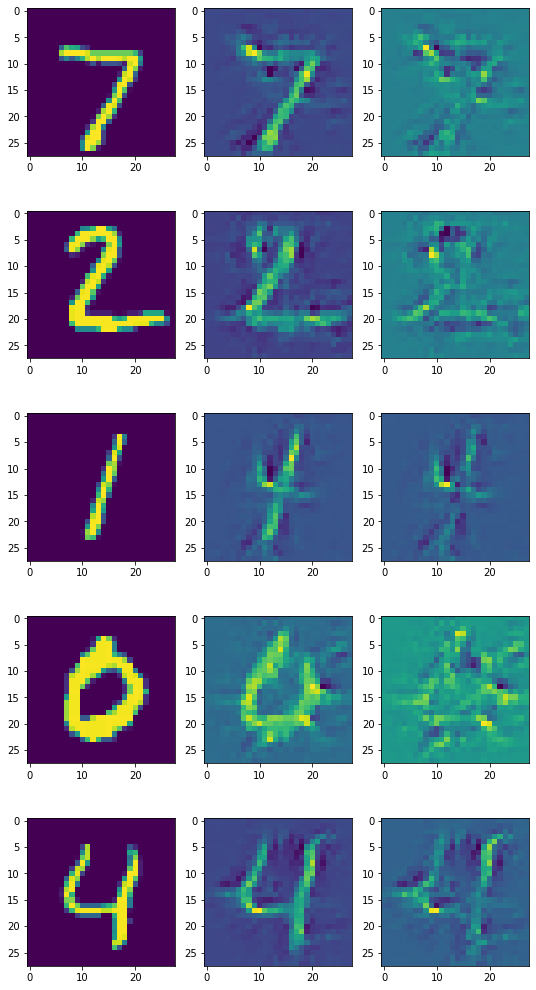

In [40]:
fig = plt.figure(figsize=(9,18))
col,row = 3,5
for i in range(1,16,3):
  ax = fig.add_subplot(row,col,i)
  plt.imshow(o_img_grid[(i-1)//3])

  ax = fig.add_subplot(row,col,i+1)
  plt.imshow(n_img_grid[(i-1)//3])

  ax = fig.add_subplot(row,col,i+2)
  plt.imshow(n_noise_grid[(i-1)//3])

plt.show()

In [41]:
cnt = 0
limit = 10
img_grid = np.zeros((limit,28,28))
noise_image_grid = np.zeros_like(img_grid)
true_class = []
pred_class = []
for image,label in visualize_loader:
  cnt += 1
  if cnt < limit:
    continue
  else:
    image = image.to(device)
    label = label.to(device)
    img_grid[cnt-limit,:,:] = image.cpu().numpy().reshape(28,28)  
    real_preds = model(image)

    # Pick any random noise. This is the noise added to make a 1 look like 4.
    add_noise = torch.from_numpy(np.asarray(n_noise_grid[2],dtype=np.float32)).to(device) 

    noisy_image = image + add_noise
    noise_image_grid[cnt-limit,:,:] = noisy_image.cpu().numpy().reshape(28,28)

    noisy_preds = model(noisy_image)
    true_class.append(np.argmax(real_preds.cpu().numpy(),axis=1))
    pred_class.append(np.argmax(noisy_preds.cpu().numpy(),axis=1))
  if cnt == 2*limit-1:
    break

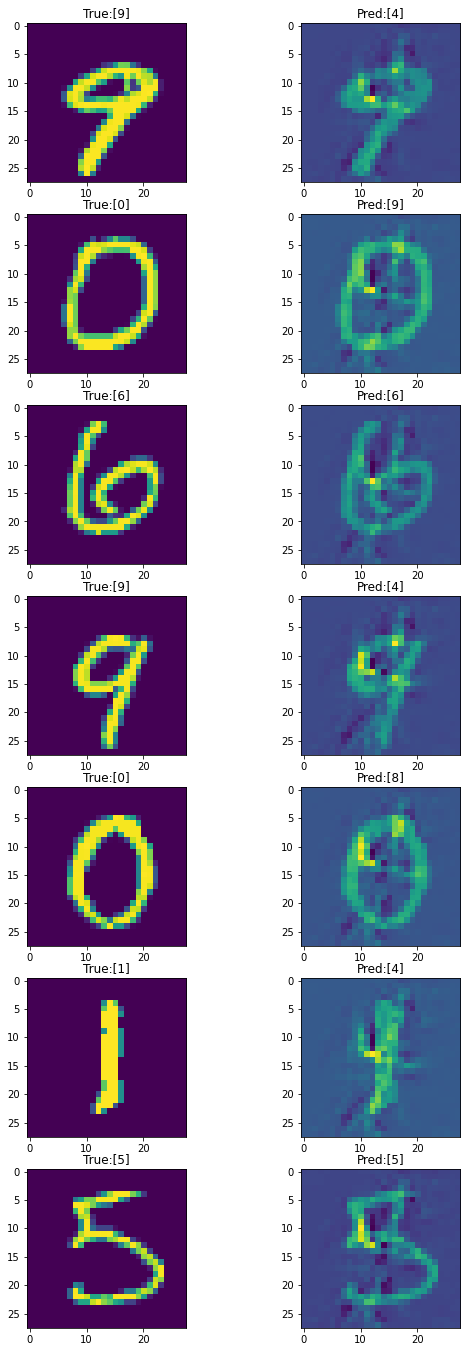

In [42]:
fig = plt.figure(figsize=(9,24))
col,row = 2,7
for i in range(1,15,2):
  ax = fig.add_subplot(row,col,i)
  ax.title.set_text('True:{}'.format(true_class[(i-1)//2]))
  plt.imshow(img_grid[(i-1)//2])

  ax = fig.add_subplot(row,col,i+1)
  ax.title.set_text('Pred:{}'.format(pred_class[(i-1)//2]))
  plt.imshow(noise_image_grid[(i-1)//2])

plt.show()